# Consolidación data entrenamiento - manejo de valores faltantes - Feature Engineering

#### Import librerias

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import datetime
from dateutil.parser import parse

**Productos target**

In [2]:
Productos_interes=["A-A", "B-B", "C-D", "D-E", "E-E"]
Productos_interes

['A-A', 'B-B', 'C-D', 'D-E', 'E-E']

#### Campañas

In [4]:
Campanas_train=pd.read_csv("../Datos/campanas_train.csv").drop(columns=["Unnamed: 0","Id_Producto",	"Tipo"])
Campanas_train

,id,Producto-Tipo,Fecha_Campaña,Periodo,Resultado,Canal,Duracion_Campaña
0,1,A-A,2020-01-02,202001,0,B,1
1,1,B-B,2020-01-21,202001,0,C,1
2,1,A-A,2020-02-03,202002,0,B,1
3,1,B-B,2020-02-18,202002,0,C,1
4,1,A-A,2020-03-02,202003,0,B,1
...,...,...,...,...,...,...,...
493323,79539,B-B,2020-01-28,202001,0,C,1
493324,79539,C-D,2020-07-20,202007,0,C,1
493325,79539,A-A,2020-07-01,202007,0,B,1
493326,79539,B-B,2020-04-08,202004,0,C,1


In [76]:
# Se utiliza columna Periodo para caracterizar clientes debido a que es una columna sin valores faltantes
Campanas_train["Periodo"]=Campanas_train["Periodo"].astype(str)
Campanas_train["date"]=Campanas_train["Periodo"].apply(lambda x: x[4:6]+'-'+'01'+'-'+x[0:4])
Campanas_train["date"]=pd.to_datetime(Campanas_train["date"],format="%d-%m-%Y") 

**Duración promedio de campaña**

In [77]:
cam_dur_camp=Campanas_train[["id","Duracion_Campaña"]].groupby("id").mean()
cam_dur_camp

,Duracion_Campaña
id,
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
...,...
79535,1.0
79536,1.0
79537,1.0


In [78]:
# Missings
cam_dur_camp.isnull().sum()

Duracion_Campaña    0
dtype: int64

**Cantidad de contactos por canal**

In [79]:
def count_product(u):
    dic_product={'B':0,'C':0}
    counts=u["Canal"].value_counts()
    for i in dic_product.keys():
        try:
            dic_product[i]=counts[i]
        except:
            1*1
    return dic_product

In [80]:
df_count_product=Campanas_train.groupby("id").apply(count_product)

In [81]:
cam_cont_canal = pd.concat({k: pd.Series(v) for k, v in df_count_product.items()},axis=1).T
cam_cont_canal

,B,C
1,4,5
2,2,9
3,2,2
4,2,5
5,6,6
...,...,...
79535,2,9
79536,2,1
79537,1,0
79538,3,1


In [82]:
cam_dur_camp.isnull().sum()

Duracion_Campaña    0
dtype: int64

#### Comunicaciones

In [5]:
Comunicaciones_train=pd.read_csv("../Datos/Comunicaciones_train.csv").drop(columns=["Unnamed: 0","Id_Producto",	"Tipo","Tipo_comunicacion"])
Comunicaciones_train.head()

,id,Producto-Tipo,Fecha,Periodo,Lectura
0,1,B-B,2020-03-02,202003,0
1,1,E-E,2020-03-20,202003,0
2,1,B-B,2020-01-09,202001,0
3,1,B-B,2020-01-28,202001,0
4,1,B-B,2020-01-21,202001,1


**Cantidad de lecturas por tipo de pruducto**

In [25]:
def count_lect(u):
    dic_product={'lec_B-B':0, 'lec_E-E':0, 'lec_D-E':0, 'lec_C-D':0, 'lec_A-A':0}
    u=u[u["Lectura"]==1]
    counts=u["Producto-Tipo"].value_counts()
    for i in dic_product.keys():
        try:
            dic_product[i]=counts[i[4:]]
        except:
            1*1
    return dic_product

In [26]:
df_count_lect=Comunicaciones_train.groupby("id").apply(count_lect)

In [27]:
com_num_lect = pd.concat({k: pd.Series(v) for k, v in df_count_lect.items()},axis=1).T
com_num_lect

,lec_B-B,lec_E-E,lec_D-E,lec_C-D,lec_A-A
1,5,0,0,0,0
2,14,1,1,3,0
3,5,0,0,0,0
4,4,0,0,4,0
5,8,0,1,1,0
...,...,...,...,...,...
79535,12,1,2,2,0
79536,1,0,0,0,2
79537,1,0,0,0,0
79538,1,0,0,0,0


In [28]:
com_num_lect.isnull().sum()

lec_B-B    0
lec_E-E    0
lec_D-E    0
lec_C-D    0
lec_A-A    0
dtype: int64

**Número de comunicaciones**

In [29]:
# Num comunicaciones
com_num_comunicaciones=pd.DataFrame(Comunicaciones_train.groupby("id").size(),columns=["num_comunicaciones"])
com_num_comunicaciones

,num_comunicaciones
id,
1,22
2,21
3,20
4,8
5,15
...,...
79535,19
79536,27
79537,10


In [31]:
com_num_comunicaciones.isnull().sum()

num_comunicaciones    0
dtype: int64

#### Transacciones

In [6]:
Transaccion_train=pd.read_csv("../Datos/Transaccion_train.csv").drop(columns=["Unnamed: 0","Fecha"])
Transaccion_train

,id,Id_Producto,Tipo,Producto-Tipo,Signo,Monto,Periodo
0,1,F,D,F-D,Positivo,377142.843750,201901
1,1,F,D,F-D,Positivo,577142.875000,201903
2,1,F,D,F-D,Positivo,548571.437500,201904
3,1,F,D,F-D,Positivo,291428.562500,201905
4,1,F,D,F-D,Positivo,405714.281250,201906
...,...,...,...,...,...,...,...
24397532,79539,G,K,G-K,Negativo,196444.718750,202006
24397533,79539,G,K,G-K,Negativo,128644.289062,202006
24397534,79539,G,K,G-K,Negativo,124086.859375,202006
24397535,79539,A,G,A-G,NaN,185393.000000,201912


In [33]:
# Tratamiento valores faltantes
Transaccion_train.fillna('Sin Info',inplace=True)

In [34]:
# Se utiliza columna Periodo para caracterizar clientes debido a que es una columna sin valores faltantes
Transaccion_train["Periodo"]=Transaccion_train["Periodo"].astype(str)
Transaccion_train["date"]=Transaccion_train["Periodo"].apply(lambda x: x[4:6]+'-'+'01'+'-'+x[0:4])
Transaccion_train["date"]=pd.to_datetime(Transaccion_train["date"],format="%d-%m-%Y") 

**Length**: Intervalo de tiempo, en días, entre la primera y la última visita del cliente. Mientras mas grande sea el valor, más fiel es el cliente.

In [35]:
length=pd.DataFrame((Transaccion_train.groupby("id").max()["date"]-Transaccion_train.groupby("id").min()["date"]).apply(lambda x: x.days)
).rename(columns={"date":"Length"})
length

,Length
id,
1,371
2,371
3,371
4,371
5,371
...,...
79535,371
79536,371
79537,371


In [36]:
length.isnull().sum()

Length    0
dtype: int64

**Monetary**: Cantidad media de dinero gastado.

In [37]:
Monetary=Transaccion_train.groupby("id").mean()
Monetary

,Monto
id,
1,180754.821871
2,303094.160627
3,144339.196858
4,734442.026124
5,154439.534968
...,...
79535,135008.940029
79536,134945.557443
79537,660761.217238


In [38]:
Monetary.isnull().sum()

Monto    0
dtype: int64

**Frequency**: Cantidad de transacciones.

In [39]:
# Generacion Frequency
Frequency=pd.DataFrame(Transaccion_train.groupby("id").size(),columns=["Frequency"])
Frequency

,Frequency
id,
1,396
2,614
3,536
4,317
5,416
...,...
79535,482
79536,465
79537,62


In [40]:
Frequency.isnull().sum()

Frequency    0
dtype: int64

**Periodicity**: Representa si los clientes visitan las tiendas con regularidad.

In [41]:
def Perio(x):
    x=x["date"]
    xf=x
    xi=x.shift(1)
    deltas=xf-xi
    deltas.dropna(inplace=True)
    std=deltas.std()
    return std

In [42]:
Periodicity=pd.DataFrame(Transaccion_train.groupby("id").apply(lambda x: Perio(x)),columns=["Periodicity"])
Periodicity["Periodicity"]=Periodicity["Periodicity"].apply(lambda x: x.days)
Periodicity

,Periodicity
id,
1,91.0
2,93.0
3,89.0
4,109.0
5,102.0
...,...
79535,105.0
79536,99.0
79537,132.0


In [43]:
Periodicity.fillna(max(Periodicity["Periodicity"]),inplace=True)

In [44]:
Periodicity.isnull().sum()

Periodicity    0
dtype: int64

**Recency**: Indica la actualidad de la interacción de un cliente con la empresa, y da información sobre la tendencia a repetir la compra.

In [45]:
# Fecha final del registro + 1 día
t_fecha_final=parse('01-10-2021')+datetime.timedelta(days=1)
t_fecha_final

datetime.datetime(2021, 1, 11, 0, 0)

In [46]:
# Generación de Recency
auxiliar=Transaccion_train[["id","date"]].copy()
auxiliar["sum_diff"]=(t_fecha_final-auxiliar["date"]).apply(lambda x: x.days)
Recency=pd.DataFrame(auxiliar.groupby("id").sum()["sum_diff"]/auxiliar.groupby("id").size()).rename(columns={0:"Recency"})
Recency

,Recency
id,
1,652.012626
2,619.035831
3,614.389925
4,634.747634
5,649.634615
...,...
79535,608.404564
79536,620.189247
79537,577.548387


In [47]:
Recency.isnull().sum()

Recency    0
dtype: int64

**Count others products**: Cantidad de compras de otros productos (no target)

In [48]:
productos_auxiliar=list(filter(lambda x:x not in Productos_interes,Transaccion_train["Producto-Tipo"].unique()))
productos_auxiliar

['F-D', 'F-H', 'F-I', 'F-J', 'G-K', 'A-G', 'A-K', 'C-C', 'D-F', 'E-F', 'A-L']

In [49]:
def count_product_int(u):
    dic_product={'F-D':0, 'F-H':0, 'F-I':0, 'F-J':0, 'G-K':0, 'A-G':0, 'A-K':0, 'C-C':0, 'D-F':0, 'E-F':0, 'A-L':0}
    counts=u["Producto-Tipo"].value_counts()
    for i in dic_product.keys():
        try:
            dic_product[i]=counts[i]
        except:
            1*1
    return dic_product
            

In [50]:
df_count_product_int=Transaccion_train.groupby("id").apply(count_product_int)

In [51]:
tran_count_product_int = pd.concat({k: pd.Series(v) for k, v in df_count_product_int.items()},axis=1).T
tran_count_product_int

,F-D,F-H,F-I,F-J,G-K,A-G,A-K,C-C,D-F,E-F,A-L
1,17,19,2,19,47,18,274,0,0,0,0
2,9,5,2,19,365,19,148,6,14,3,0
3,15,19,5,19,163,37,257,0,0,10,1
4,1,5,12,19,181,17,62,0,4,5,1
5,2,17,16,17,266,16,69,0,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...
79535,9,9,18,19,247,18,141,0,7,2,0
79536,8,7,18,16,258,17,141,0,0,0,0
79537,17,7,0,19,0,1,2,3,0,4,0
79538,2,13,15,18,56,19,78,0,2,2,0


In [52]:
tran_count_product_int.isnull().sum()

F-D    0
F-H    0
F-I    0
F-J    0
G-K    0
A-G    0
A-K    0
C-C    0
D-F    0
E-F    0
A-L    0
dtype: int64

**Count Signo Negativo, positivo, sin info**

In [53]:
def count_sign(u):
    dic_sign={'Positivo':0, 'Negativo':0, 'Sin Info':0}
    counts=u["Signo"].value_counts()
    for i in dic_sign.keys():
        try:
            dic_sign[i]=counts[i]
        except:
            1*1
    return dic_sign

In [54]:
df_count_sign=Transaccion_train.groupby("id").apply(count_sign)

In [55]:
tran_count_sign = pd.concat({k: pd.Series(v) for k, v in df_count_sign.items()},axis=1).T
tran_count_sign

,Positivo,Negativo,Sin Info
1,36,342,18
2,51,544,19
3,44,455,37
4,29,271,17
5,23,377,16
...,...,...,...
79535,37,427,18
79536,24,424,17
79537,45,16,1
79538,22,167,19


In [56]:
tran_count_sign.isnull().sum()

Positivo    0
Negativo    0
Sin Info    0
dtype: int64

#### Consumidores

In [7]:
Consumidores=pd.read_csv("../Datos/Consumidores.csv",sep=',').drop(columns=["Unnamed: 0"])
Consumidores

,Edad,Sexo,Renta,Recibe_sueldo_en_cuenta,Segmento_consumidor,Meses_antiguedad,Comuna,Ciudad,Estado_civil,Principalidad,Profesion,id
0,Mayor a 70,1,R1,0,A,Mayor a 10 años,331.0,13.0,D,B,P164,1
1,Mayor a 70,1,R9,0,B,Mayor a 10 años,37.0,5.0,D,E,P164,2
2,Mayor a 70,1,R9,1,B,Mayor a 10 años,19.0,4.0,B,D,P114,3
3,Mayor a 70,1,R10,0,B,Mayor a 10 años,37.0,5.0,B,C,P164,4
4,Mayor a 70,1,R4,0,A,Mayor a 10 años,91.0,13.0,D,B,P85,5
...,...,...,...,...,...,...,...,...,...,...,...,...
79534,Entre 30 y 35,0,R2,0,A,Menos de 1 año,189.0,8.0,A,NaN,NaN,79535
79535,Entre 35 y 40,0,R1,0,A,Menos de 1 año,72.0,13.0,B,NaN,NaN,79536
79536,Entre 50 y 55,1,R1,0,A,Menos de 1 año,342.0,8.0,B,NaN,NaN,79537
79537,Entre 45 y 50,0,R2,0,A,Menos de 1 año,71.0,13.0,A,NaN,NaN,79538


In [58]:
# Tratamiento de valores faltantes
Consumidores.fillna('Sin Info',inplace=True)

In [59]:
# Set index para merge
Consumidores.set_index("id",inplace=True)

**Generación de target**: A partir de transacciones y campañas con resultado=1

In [60]:
def orden_productos(z):
    z=z.sort_values("date")
    z=z[z["Producto-Tipo"].isin(Productos_interes)]
    productos=[]
    for i in range(len(z)):
        if i==0:
            productos.append(z["Producto-Tipo"].iloc[i])
        while len(productos)<=5 and (z["Producto-Tipo"].iloc[i] not in productos):
            productos.append(z["Producto-Tipo"].iloc[i])


    while len(productos)<5:
        productos.append('')

    orden_productos=" ".join(list(filter(lambda x: x!="",productos)))
    return orden_productos
    

In [84]:
auxiliar_target=pd.concat([Campanas_train.query("Resultado==1")[["id","Producto-Tipo","date"]],
Transaccion_train[["id","Producto-Tipo","date"]]]
)
auxiliar_target

,id,Producto-Tipo,date
164,25,C-D,2020-01-02
173,25,A-A,2020-01-06
220,30,A-A,2020-01-06
348,45,C-D,2020-01-06
351,45,C-D,2020-01-04
...,...,...,...
24397532,79539,G-K,2020-01-06
24397533,79539,G-K,2020-01-06
24397534,79539,G-K,2020-01-06
24397535,79539,A-G,2019-01-12


In [85]:
Target=pd.DataFrame(auxiliar_target.groupby("id").apply(lambda x: orden_productos(x)),columns=["Target"])
Target

,Target
id,
1,
2,D-E C-D E-E B-B
3,E-E A-A B-B
4,B-B E-E D-E A-A
5,E-E B-B D-E
...,...
79535,B-B E-E D-E
79536,
79537,E-E C-D D-E


In [86]:
Target.value_counts() 

Target             
                       12090
D-E                     7934
B-B                     4590
D-E B-B                 4380
E-E                     4008
                       ...  
A-A C-D B-B E-E D-E        1
A-A E-E B-B C-D D-E        1
E-E B-B A-A C-D D-E        1
A-A B-B C-D D-E E-E        1
A-A B-B D-E E-E C-D        1
Length: 323, dtype: int64

In [87]:
# Merges 1
Data=cam_dur_camp.merge(cam_cont_canal,how="outer",left_index=True,right_index=True)

# Merges 2
Data=Data.merge(com_num_lect,how="outer",left_index=True,right_index=True)

# Merges 3
Data=Data.merge(com_num_comunicaciones,how="outer",left_index=True,right_index=True)

# Merges 4
Data=Data.merge(length,how="outer",left_index=True,right_index=True)


# Merges 5
Data=Data.merge(Monetary,how="outer",left_index=True,right_index=True)

# Merges 6
Data=Data.merge(Frequency,how="outer",left_index=True,right_index=True)

# Merges 7
Data=Data.merge(Periodicity,how="outer",left_index=True,right_index=True)

# Merges 8
Data=Data.merge(Recency,how="outer",left_index=True,right_index=True)

# Merges 9
Data=Data.merge(tran_count_product_int,how="outer",left_index=True,right_index=True)

# Merges 10
Data=Data.merge(tran_count_sign,how="outer",left_index=True,right_index=True)

# Merge 11
Data=Data.merge(Consumidores,how="outer",left_index=True,right_index=True)


# Merges 12
Data=Data.merge(Target,how="outer",left_index=True,right_index=True)



<AxesSubplot:>

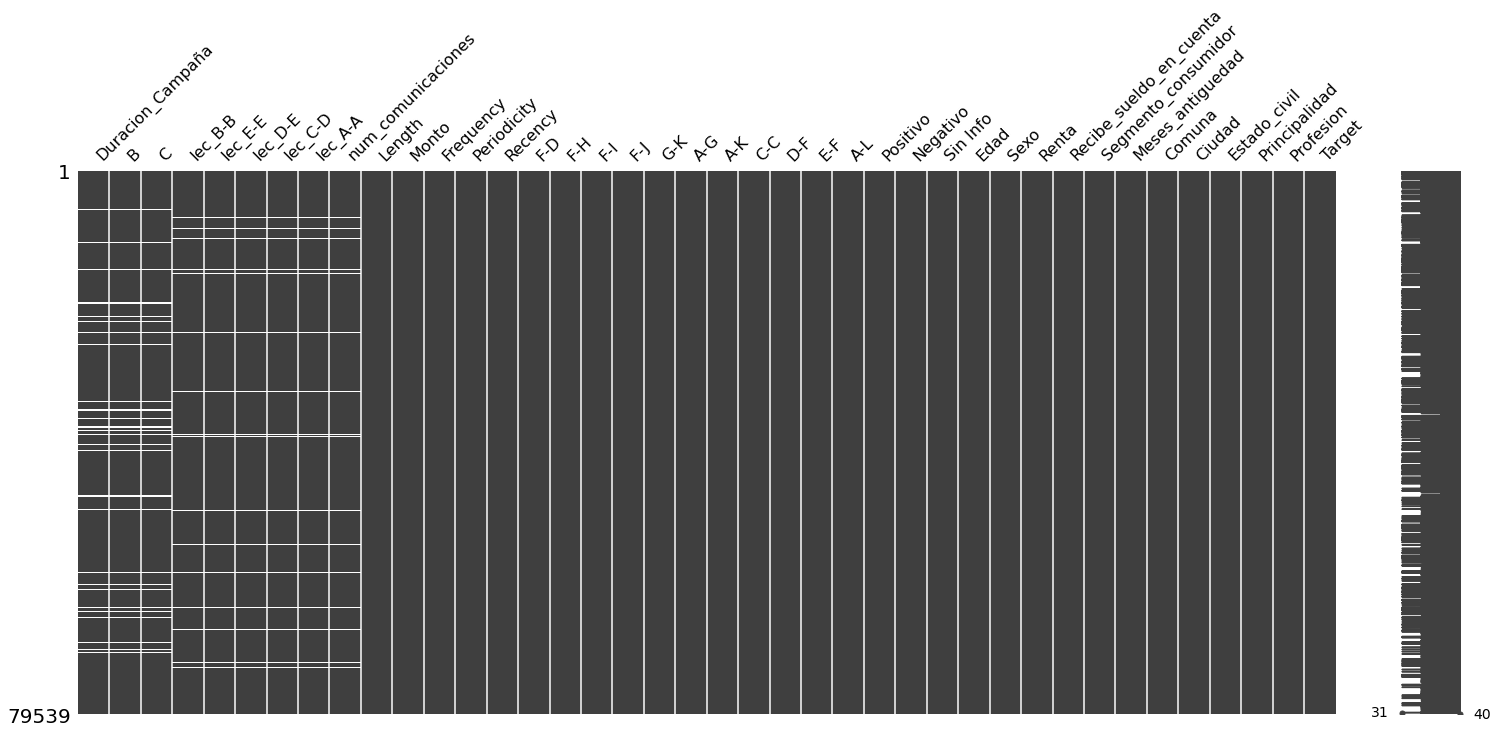

In [88]:
# Missings
msno.matrix(Data)

In [89]:
# Columnas con al menos 1 nan
Data.columns[Data.isnull().any(axis=0)]

Index(['Duracion_Campaña', 'B', 'C', 'lec_B-B', 'lec_E-E', 'lec_D-E',
       'lec_C-D', 'lec_A-A', 'num_comunicaciones'],
      dtype='object')

In [90]:
# Por el contexto del problema y al ser columnas númericas el tratamiento será reemplazar estos contadores por valor 0
Data.fillna(0,inplace=True)


In [91]:
# Columnas con al menos 1 nan
Data.columns[Data.isnull().any(axis=0)]

Index([], dtype='object')

<AxesSubplot:>

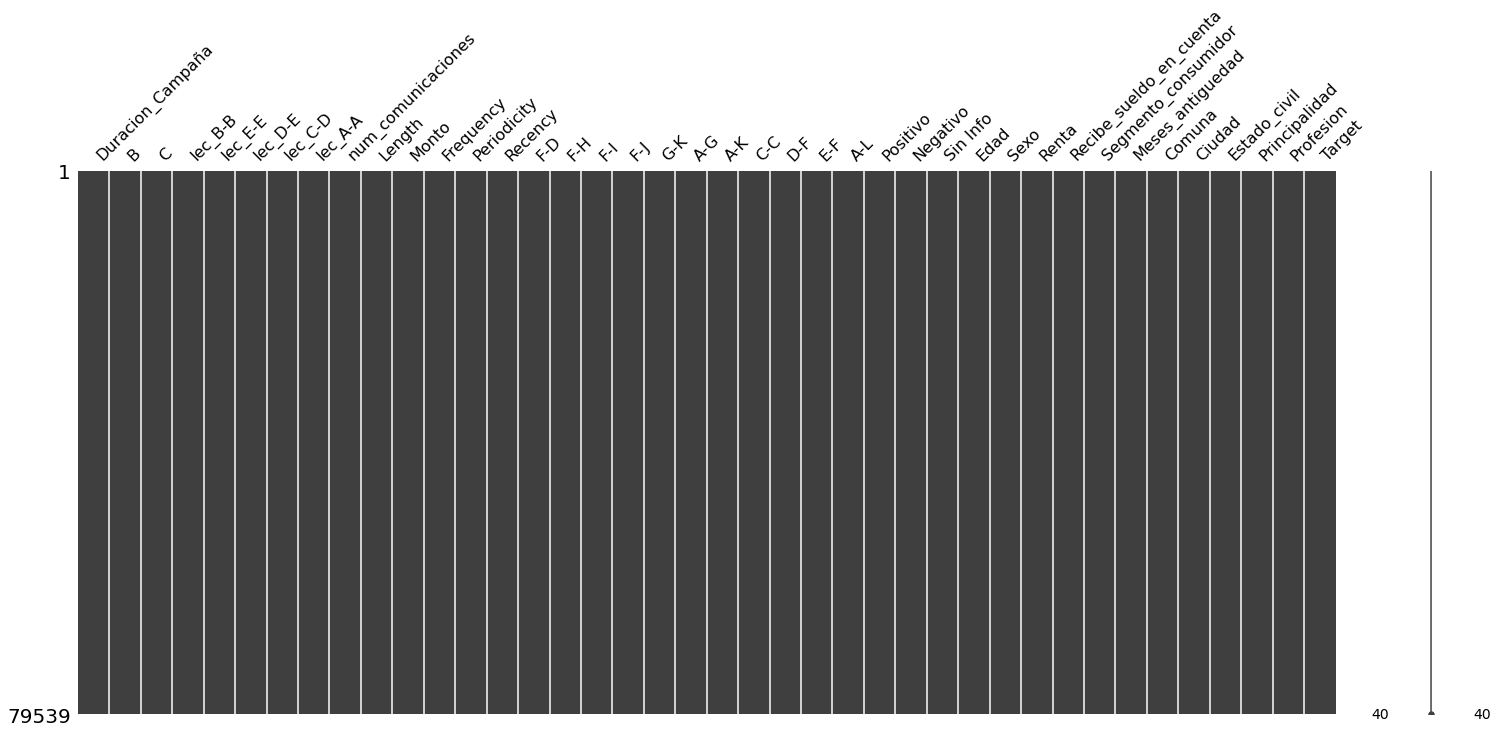

In [92]:
# Missings
msno.matrix(Data)

In [93]:
Data.shape

(79539, 40)

In [94]:
# Se guarda raw en csv
Data.to_csv('../Datos/consolidation_'+pd.to_datetime('today').strftime('%d%B%Y')+'.csv', index=True)